# Goal:

Develop a model that outputs the expected number of user ratings on the website Vivino.com when input the price and quality rating of the wine.

### No correlation found between wine price and quality and how many Vivino users rate the wine.
Searched over many pricing and number of ratings ranges, sliced data on wines made in the US, those made in Napa Valley, and without any regional condition.  R^2 never exceeded 0.15

In [1]:
import matplotlib.pyplot as plt
import pandas            as pds
import seaborn           as sns
import numpy             as np
import sklearn

#Regression Modeling
from sklearn.linear_model    import Lasso as LSO, ElasticNet as ELN, Ridge as RDG
from sklearn.svm             import SVR
from sklearn.ensemble        import RandomForestRegressor as RFR, GradientBoostingRegressor as GBR
from sklearn.ensemble        import AdaBoostRegressor as ABR
#Testing
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics         import classification_report as cr, r2_score as r2
from sklearn.metrics         import accuracy_score as ac, mean_squared_error as mse
#Outlier Detection
from sklearn.neighbors       import LocalOutlierFactor as LOF
from sklearn.ensemble        import IsolationForest as ISF
from sklearn.covariance      import EllipticEnvelope as ELE
from sklearn.decomposition   import PCA


df = pds.read_csv('vivino_white_wine.csv', sep=",", header=0, encoding='ISO-8859-15')
df['rating']     = df['rating'].astype(float)
df['pricing']    = df['pricing'].str.replace('$', '')
df['pricing']    = df['pricing'].astype(float)
df['popularity'] = df['popularity'].astype(float)

Number of data entries in sliced database:  949


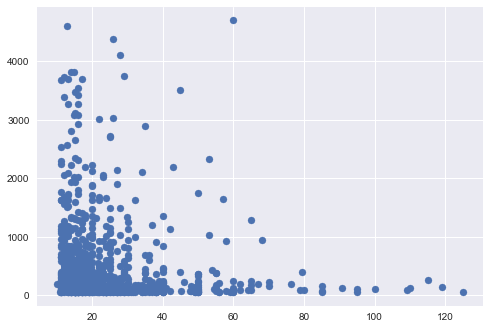

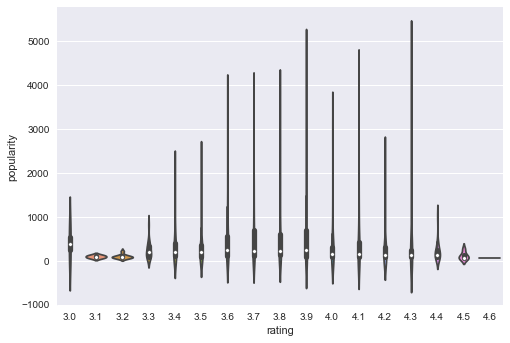

In [2]:
# print(df[(df['country'] == 'United States')].region.unique())

max_pricing = 125
min_popularity = 50
country = 'United States'
max_popularity = 5000

df_mod = df[(df['pricing'] < max_pricing) & (abs(df['popularity']) > min_popularity) & \
         (abs(df['popularity']) < max_popularity) & (df['country'] == country)]#(df['region'] == 'Napa Valley')]
df_mod.index = range(len(df_mod)); df_mod = df_mod.drop('Unnamed: 0', 1)
print('Number of data entries in sliced database: ', len(df_mod))
plt.scatter(df_mod['pricing'], df_mod['popularity'])
plt.show()

sns.violinplot(df_mod['rating'], df_mod['popularity'])
plt.show()

In [3]:
df_mod.copy()
ft = df_mod.columns[-3:]
print(ft)
df_results = df_mod[ft[:2]]
df_targets = df_mod[ft[-1]]

Index(['rating', 'pricing', 'popularity'], dtype='object')


In [4]:
LOF_list = LOF().fit_predict(df_mod[ft])
ISF_fit  = ISF().fit(df_mod[ft])
ISF_list = ISF_fit.predict(df_mod[ft])

LOF_outliers = []; ISF_outliers = []
for i in range(len(LOF_list)):
    if LOF_list[i] == -1:
        LOF_outliers.append(i)
    if ISF_list[i] == -1:
        ISF_outliers.append(i)

print('number of points cut by LOF outlier search: ', len(LOF_outliers))
print('number of points cut by ISF outlier search: ', len(ISF_outliers))

df_LOF       = df_mod.drop(df_mod.index[LOF_outliers])
df_LOF.index = range(len(df_LOF))
df_ISF       = df_mod.drop(df_mod.index[ISF_outliers])
df_ISF.index = range(len(df_ISF))

df_LOF_PCA               = pds.DataFrame(PCA().fit_transform(df_LOF[ft[:2]]))
df_ISF_PCA               = pds.DataFrame(PCA().fit_transform(df_ISF[ft[:2]]))
df_PCA                   = pds.DataFrame(PCA().fit_transform(df_mod[ft[:2]]))
df_LOF_PCA['popularity'] = df_LOF['popularity']
df_ISF_PCA['popularity'] = df_ISF['popularity']
df_PCA['popularity']     = df_mod['popularity']

print('\n')
print('Number of empty cells in df_LOF_PCA: ', df_LOF_PCA.isnull().sum().sum())
print('Number of empty cells in df_ISF_PCA: ', df_ISF_PCA.isnull().sum().sum())
print('Number of empty cells in df_PCA    : ', df_PCA.isnull().sum().sum())
print('\n')
print('Total number of rows in df_LOF_PCA: ', len(df_LOF_PCA))
print('Total number of rows in df_ISF_PCA: ', len(df_ISF_PCA))
print('Total number of rows in df_PCA    : ', len(df_PCA))

number of points cut by LOF outlier search:  95
number of points cut by ISF outlier search:  95


Number of empty cells in df_LOF_PCA:  0
Number of empty cells in df_ISF_PCA:  0
Number of empty cells in df_PCA    :  0


Total number of rows in df_LOF_PCA:  854
Total number of rows in df_ISF_PCA:  854
Total number of rows in df_PCA    :  949


## Raw Data Analysis

In [5]:
training_list = []; testing_list = []
for i in range(20):
    train, test = tts(df_mod, test_size=0.2)
    training_list.append(train)
    testing_list.append(test)
LSO_RAW_models = []; ELN_RAW_models = []; RDG_RAW_models = []; ABR_RAW_models = []
GBR_RAW_models = []; RFR_RAW_models = []; SVR_RAW_models = []
for training_set in training_list:
    model = LSO(); LSO_RAW_models.append(model.fit(training_set[ft[:2]], training_set[ft[-1]]))
    model = ELN(); ELN_RAW_models.append(model.fit(training_set[ft[:2]], training_set[ft[-1]]))
    model = RDG(); RDG_RAW_models.append(model.fit(training_set[ft[:2]], training_set[ft[-1]])) 
    model = GBR(); GBR_RAW_models.append(model.fit(training_set[ft[:2]], training_set[ft[-1]])) 
    model = RFR(); RFR_RAW_models.append(model.fit(training_set[ft[:2]], training_set[ft[-1]]))
    model = ABR(); ABR_RAW_models.append(model.fit(training_set[ft[:2]], training_set[ft[-1]]))
    model = SVR(kernel='rbf'); SVR_RAW_models.append(model.fit(training_set[ft[:2]], training_set[ft[-1]]))

In [6]:
LSO_RAW_predicted = []; ELN_RAW_predicted = []; RDG_RAW_predicted = []; GBR_RAW_predicted = [] 
RFR_RAW_predicted = []; SVR_RAW_predicted = []; ABR_RAW_predicted = []; RAW_expected = []
for i in range(len(testing_list)):
    LSO_RAW_predicted.extend(LSO_RAW_models[i].predict(testing_list[i][ft[:2]]))
    ELN_RAW_predicted.extend(ELN_RAW_models[i].predict(testing_list[i][ft[:2]]))
    RDG_RAW_predicted.extend(RDG_RAW_models[i].predict(testing_list[i][ft[:2]]))
    GBR_RAW_predicted.extend(GBR_RAW_models[i].predict(testing_list[i][ft[:2]]))
    RFR_RAW_predicted.extend(RFR_RAW_models[i].predict(testing_list[i][ft[:2]]))
    SVR_RAW_predicted.extend(SVR_RAW_models[i].predict(testing_list[i][ft[:2]]))
    ABR_RAW_predicted.extend(ABR_RAW_models[i].predict(testing_list[i][ft[:2]]))
    RAW_expected.extend(testing_list[i][ft[-1]])

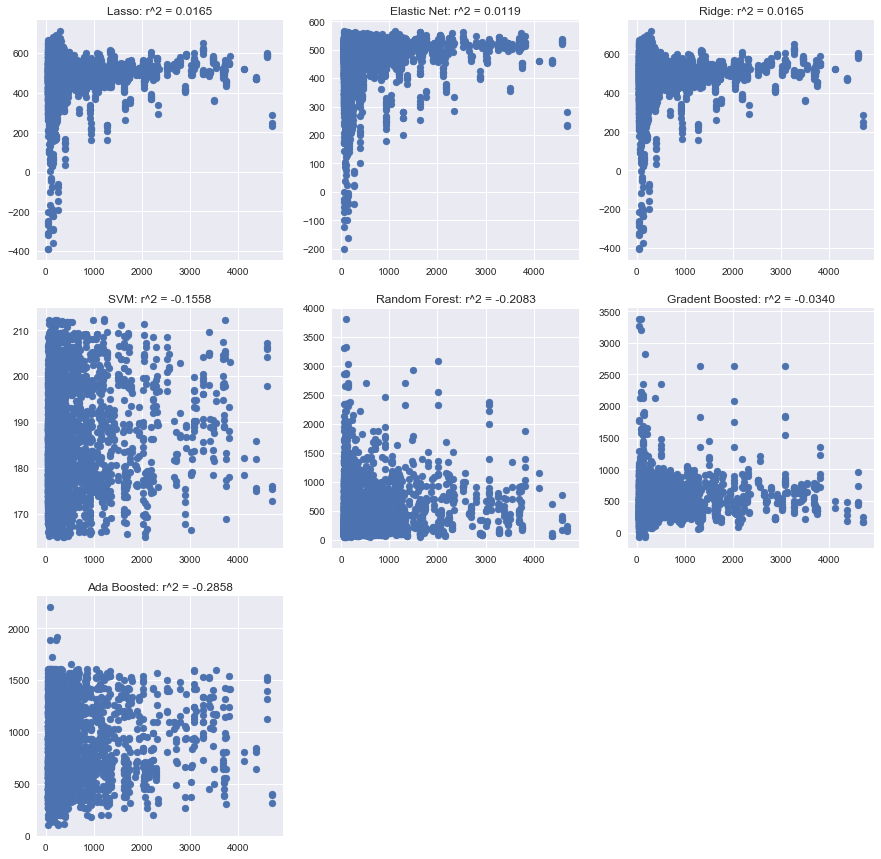

In [7]:
plt.figure(1, figsize=(15, 15))
plt.subplot(3,3,1); plt.scatter(RAW_expected, LSO_RAW_predicted) 
plt.title('Lasso: r^2 = {0:.4f}'.format(r2(RAW_expected, LSO_RAW_predicted)))
plt.subplot(3,3,2); plt.scatter(RAW_expected, ELN_RAW_predicted) 
plt.title('Elastic Net: r^2 = {0:.4f}'.format(r2(RAW_expected, ELN_RAW_predicted)))
plt.subplot(3,3,3); plt.scatter(RAW_expected, RDG_RAW_predicted); 
plt.title('Ridge: r^2 = {0:.4f}'.format(r2(RAW_expected, RDG_RAW_predicted)))
plt.subplot(3,3,4); plt.scatter(RAW_expected, SVR_RAW_predicted); 
plt.title('SVM: r^2 = {0:.4f}'.format(r2(RAW_expected, SVR_RAW_predicted)))
plt.subplot(3,3,5); plt.scatter(RAW_expected, RFR_RAW_predicted); 
plt.title('Random Forest: r^2 = {0:.4f}'.format(r2(RAW_expected, RFR_RAW_predicted)))
plt.subplot(3,3,6); plt.scatter(RAW_expected, GBR_RAW_predicted); 
plt.title('Gradent Boosted: r^2 = {0:.4f}'.format(r2(RAW_expected, GBR_RAW_predicted)))
plt.subplot(3,3,7); plt.scatter(RAW_expected, ABR_RAW_predicted); 
plt.title('Ada Boosted: r^2 = {0:.4f}'.format(r2(RAW_expected, ABR_RAW_predicted)))
plt.show()

In [199]:
training_list = []; testing_list = []
for i in range(20):
    train, test = tts(df_LOF, test_size=0.2)
    training_list.append(train)
    testing_list.append(test)
LSO_models = []; ELN_models = []; RDG_models = []
GBR_models = []; RFR_models = []; SVR_models = []
for training_set in training_list:
    model = LSO(); LSO_models.append(model.fit(training_set[ft[:2]], training_set[ft[-1]]))
    model = ELN(); ELN_models.append(model.fit(training_set[ft[:2]], training_set[ft[-1]]))
    model = RDG(); RDG_models.append(model.fit(training_set[ft[:2]], training_set[ft[-1]])) 
    model = GBR(); GBR_models.append(model.fit(training_set[ft[:2]], training_set[ft[-1]])) 
    model = RFR(); RFR_models.append(model.fit(training_set[ft[:2]], training_set[ft[-1]]))   
    model = SVR(kernel='rbf'); SVR_models.append(model.fit(training_set[ft[:2]], training_set[ft[-1]]))

In [200]:
LSO_predicted = []; ELN_predicted = []; RDG_predicted = []; GBR_predicted = [] 
RFR_predicted = []; SVR_predicted = []; Expected = []
for i in range(len(testing_list)):
    LSO_predicted.extend(LSO_models[i].predict(testing_list[i][ft[:2]]))
    ELN_predicted.extend(ELN_models[i].predict(testing_list[i][ft[:2]]))
    RDG_predicted.extend(RDG_models[i].predict(testing_list[i][ft[:2]]))
    GBR_predicted.extend(GBR_models[i].predict(testing_list[i][ft[:2]]))
    RFR_predicted.extend(RFR_models[i].predict(testing_list[i][ft[:2]]))
    SVR_predicted.extend(SVR_models[i].predict(testing_list[i][ft[:2]]))
    Expected.extend(testing_list[i][ft[-1]])

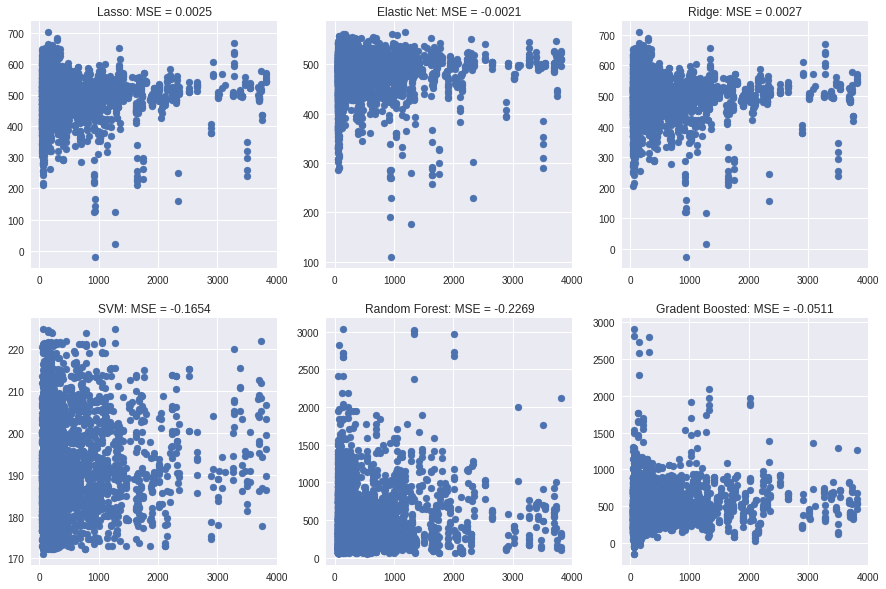

In [201]:
plt.figure(1, figsize=(15, 10))
plt.subplot(2,3,1); plt.scatter(Expected, LSO_predicted) 
plt.title('Lasso: MSE = {0:.4f}'.format(r2(Expected, LSO_predicted)))
plt.subplot(2,3,2); plt.scatter(Expected, ELN_predicted) 
plt.title('Elastic Net: MSE = {0:.4f}'.format(r2(Expected, ELN_predicted)))
plt.subplot(2,3,3); plt.scatter(Expected, RDG_predicted); 
plt.title('Ridge: MSE = {0:.4f}'.format(r2(Expected, RDG_predicted)))
plt.subplot(2,3,4); plt.scatter(Expected, SVR_predicted); 
plt.title('SVM: MSE = {0:.4f}'.format(r2(Expected, SVR_predicted)))
plt.subplot(2,3,5); plt.scatter(Expected, RFR_predicted); 
plt.title('Random Forest: MSE = {0:.4f}'.format(r2(Expected, RFR_predicted)))
plt.subplot(2,3,6); plt.scatter(Expected, GBR_predicted); 
plt.title('Gradent Boosted: MSE = {0:.4f}'.format(r2(Expected, GBR_predicted)))
plt.show()

In [202]:
training_list = []; testing_list = []
for i in range(20):
    train, test = tts(df_LOF, test_size=0.2)
    training_list.append(train)
    testing_list.append(test)
LSO_models = []; ELN_models = []; RDG_models = []
GBR_models = []; RFR_models = []; SVR_models = []
for training_set in training_list:
    model = LSO(); LSO_models.append(model.fit(training_set[ft[:2]], training_set[ft[-1]]))
    model = ELN(); ELN_models.append(model.fit(training_set[ft[:2]], training_set[ft[-1]]))
    model = RDG(); RDG_models.append(model.fit(training_set[ft[:2]], training_set[ft[-1]])) 
    model = GBR(); GBR_models.append(model.fit(training_set[ft[:2]], training_set[ft[-1]])) 
    model = RFR(); RFR_models.append(model.fit(training_set[ft[:2]], training_set[ft[-1]]))   
    model = SVR(kernel='rbf'); SVR_models.append(model.fit(training_set[ft[:2]], training_set[ft[-1]]))

In [203]:
LSO_predicted = []; ELN_predicted = []; RDG_predicted = []; GBR_predicted = [] 
RFR_predicted = []; SVR_predicted = []; Expected = []
for i in range(len(testing_list)):
    LSO_predicted.extend(LSO_models[i].predict(testing_list[i][ft[:2]]))
    ELN_predicted.extend(ELN_models[i].predict(testing_list[i][ft[:2]]))
    RDG_predicted.extend(RDG_models[i].predict(testing_list[i][ft[:2]]))
    GBR_predicted.extend(GBR_models[i].predict(testing_list[i][ft[:2]]))
    RFR_predicted.extend(RFR_models[i].predict(testing_list[i][ft[:2]]))
    SVR_predicted.extend(SVR_models[i].predict(testing_list[i][ft[:2]]))
    Expected.extend(testing_list[i][ft[-1]])

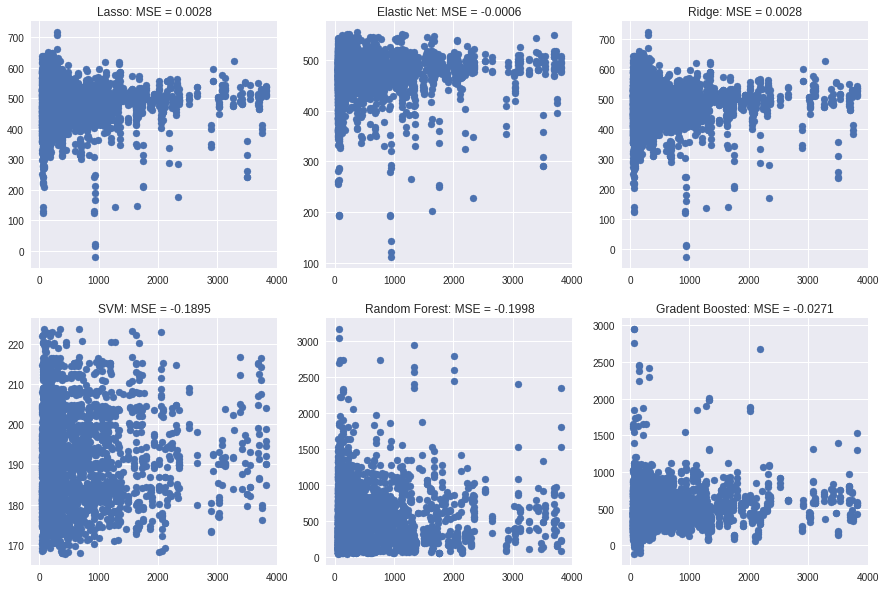

In [204]:
plt.figure(1, figsize=(15, 10))
plt.subplot(2,3,1); plt.scatter(Expected, LSO_predicted) 
plt.title('Lasso: MSE = {0:.4f}'.format(r2(Expected, LSO_predicted)))
plt.subplot(2,3,2); plt.scatter(Expected, ELN_predicted) 
plt.title('Elastic Net: MSE = {0:.4f}'.format(r2(Expected, ELN_predicted)))
plt.subplot(2,3,3); plt.scatter(Expected, RDG_predicted); 
plt.title('Ridge: MSE = {0:.4f}'.format(r2(Expected, RDG_predicted)))
plt.subplot(2,3,4); plt.scatter(Expected, SVR_predicted); 
plt.title('SVM: MSE = {0:.4f}'.format(r2(Expected, SVR_predicted)))
plt.subplot(2,3,5); plt.scatter(Expected, RFR_predicted); 
plt.title('Random Forest: MSE = {0:.4f}'.format(r2(Expected, RFR_predicted)))
plt.subplot(2,3,6); plt.scatter(Expected, GBR_predicted); 
plt.title('Gradent Boosted: MSE = {0:.4f}'.format(r2(Expected, GBR_predicted)))
plt.show()

In [205]:
training_list = []; testing_list = []
for i in range(20):
    train, test = tts(df_ISF, test_size=0.2)
    training_list.append(train)
    testing_list.append(test)
LSO_models = []; ELN_models = []; RDG_models = []
GBR_models = []; RFR_models = []; SVR_models = []
for training_set in training_list:
    model = LSO(); LSO_models.append(model.fit(training_set[ft[:2]], training_set[ft[-1]]))
    model = ELN(); ELN_models.append(model.fit(training_set[ft[:2]], training_set[ft[-1]]))
    model = RDG(); RDG_models.append(model.fit(training_set[ft[:2]], training_set[ft[-1]])) 
    model = GBR(); GBR_models.append(model.fit(training_set[ft[:2]], training_set[ft[-1]])) 
    model = RFR(); RFR_models.append(model.fit(training_set[ft[:2]], training_set[ft[-1]]))   
    model = SVR(kernel='rbf'); SVR_models.append(model.fit(training_set[ft[:2]], training_set[ft[-1]]))

In [206]:
LSO_predicted = []; ELN_predicted = []; RDG_predicted = []; GBR_predicted = [] 
RFR_predicted = []; SVR_predicted = []; Expected = []
for i in range(len(testing_list)):
    LSO_predicted.extend(LSO_models[i].predict(testing_list[i][ft[:2]]))
    ELN_predicted.extend(ELN_models[i].predict(testing_list[i][ft[:2]]))
    RDG_predicted.extend(RDG_models[i].predict(testing_list[i][ft[:2]]))
    GBR_predicted.extend(GBR_models[i].predict(testing_list[i][ft[:2]]))
    RFR_predicted.extend(RFR_models[i].predict(testing_list[i][ft[:2]]))
    SVR_predicted.extend(SVR_models[i].predict(testing_list[i][ft[:2]]))
    Expected.extend(testing_list[i][ft[-1]])

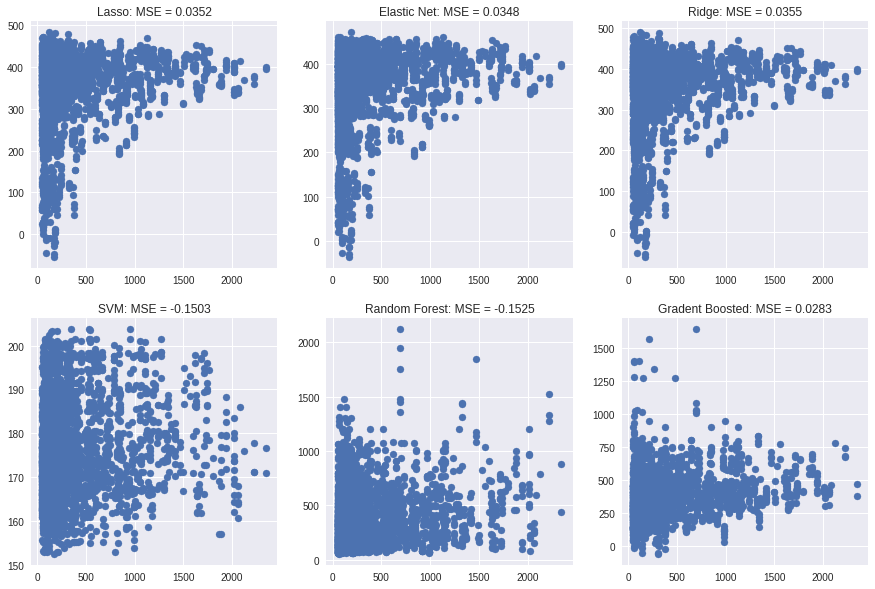

In [207]:
plt.figure(1, figsize=(15, 10))
plt.subplot(2,3,1); plt.scatter(Expected, LSO_predicted) 
plt.title('Lasso: MSE = {0:.4f}'.format(r2(Expected, LSO_predicted)))
plt.subplot(2,3,2); plt.scatter(Expected, ELN_predicted) 
plt.title('Elastic Net: MSE = {0:.4f}'.format(r2(Expected, ELN_predicted)))
plt.subplot(2,3,3); plt.scatter(Expected, RDG_predicted); 
plt.title('Ridge: MSE = {0:.4f}'.format(r2(Expected, RDG_predicted)))
plt.subplot(2,3,4); plt.scatter(Expected, SVR_predicted); 
plt.title('SVM: MSE = {0:.4f}'.format(r2(Expected, SVR_predicted)))
plt.subplot(2,3,5); plt.scatter(Expected, RFR_predicted); 
plt.title('Random Forest: MSE = {0:.4f}'.format(r2(Expected, RFR_predicted)))
plt.subplot(2,3,6); plt.scatter(Expected, GBR_predicted); 
plt.title('Gradent Boosted: MSE = {0:.4f}'.format(r2(Expected, GBR_predicted)))
plt.show()

In [208]:
training_list = []; testing_list = []
ft = df_PCA.columns
for i in range(20):
    train, test = tts(df_PCA, test_size=0.2)
    training_list.append(train)
    testing_list.append(test)
LSO_models = []; ELN_models = []; RDG_models = []
GBR_models = []; RFR_models = []; SVR_models = []
for training_set in training_list:
    model = LSO(); LSO_models.append(model.fit(training_set[ft[:2]], training_set[ft[-1]]))
    model = ELN(); ELN_models.append(model.fit(training_set[ft[:2]], training_set[ft[-1]]))
    model = RDG(); RDG_models.append(model.fit(training_set[ft[:2]], training_set[ft[-1]])) 
    model = GBR(); GBR_models.append(model.fit(training_set[ft[:2]], training_set[ft[-1]])) 
    model = RFR(); RFR_models.append(model.fit(training_set[ft[:2]], training_set[ft[-1]]))   
    model = SVR(kernel='rbf'); SVR_models.append(model.fit(training_set[ft[:2]], training_set[ft[-1]]))

In [209]:
LSO_predicted = []; ELN_predicted = []; RDG_predicted = []; GBR_predicted = [] 
RFR_predicted = []; SVR_predicted = []; Expected = []
for i in range(len(testing_list)):
    LSO_predicted.extend(LSO_models[i].predict(testing_list[i][ft[:2]]))
    ELN_predicted.extend(ELN_models[i].predict(testing_list[i][ft[:2]]))
    RDG_predicted.extend(RDG_models[i].predict(testing_list[i][ft[:2]]))
    GBR_predicted.extend(GBR_models[i].predict(testing_list[i][ft[:2]]))
    RFR_predicted.extend(RFR_models[i].predict(testing_list[i][ft[:2]]))
    SVR_predicted.extend(SVR_models[i].predict(testing_list[i][ft[:2]]))
    Expected.extend(testing_list[i][ft[-1]])

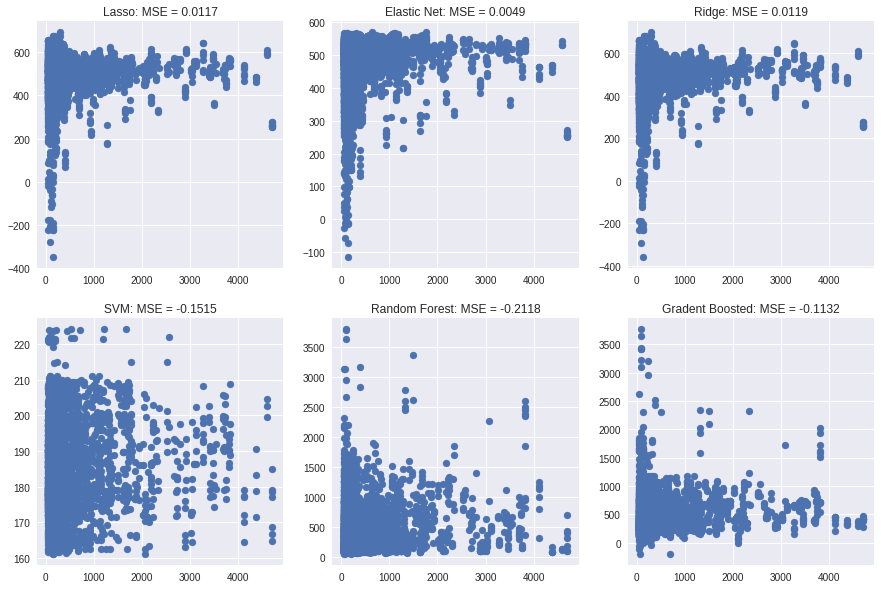

In [210]:
plt.figure(1, figsize=(15, 10))
plt.subplot(2,3,1); plt.scatter(Expected, LSO_predicted) 
plt.title('Lasso: MSE = {0:.4f}'.format(r2(Expected, LSO_predicted)))
plt.subplot(2,3,2); plt.scatter(Expected, ELN_predicted) 
plt.title('Elastic Net: MSE = {0:.4f}'.format(r2(Expected, ELN_predicted)))
plt.subplot(2,3,3); plt.scatter(Expected, RDG_predicted); 
plt.title('Ridge: MSE = {0:.4f}'.format(r2(Expected, RDG_predicted)))
plt.subplot(2,3,4); plt.scatter(Expected, SVR_predicted); 
plt.title('SVM: MSE = {0:.4f}'.format(r2(Expected, SVR_predicted)))
plt.subplot(2,3,5); plt.scatter(Expected, RFR_predicted); 
plt.title('Random Forest: MSE = {0:.4f}'.format(r2(Expected, RFR_predicted)))
plt.subplot(2,3,6); plt.scatter(Expected, GBR_predicted); 
plt.title('Gradent Boosted: MSE = {0:.4f}'.format(r2(Expected, GBR_predicted)))
plt.show()